# Doing quick surface photometry of a galaxy given its coordinates

Owners: **Aaron Watkins, Nushkia Chamba**  
Last Verified to Run: **15 July 2020**  
Verified Stack release: **20.0.0+7**

### Objectives: 

This worksheet is a demonstration of how to do the following:
1. Locate a specific object from available databases in the Stack using its right ascension and declination coordinates
2. Obtain a thumbnail of the object for image analysis
3. Mask unwanted sources surrounding and overlapping the object using source detection footprints
4. Do quick surface photometry of the object on the masked image, with a local background estimation

The basic goal is to provide a demonstration of one way to perform one's own image analysis within the Stack, on present and future imaging data releases.  It can be used as a stepping off point for development of one's own software.

NOTE: certain parts of this notebook require a session with Large (4 MB) memory.  The Scarlet deblending in particular will likely time out if you use a smaller session.

## **Initial Setup**

In [1]:
# What version of the Stack am I using?
! echo $HOSTNAME
! eups list lsst_distrib -s

nb-chamba-w-2020-30
   20.0.0-1-g0037e03+14 	current w_2020_30 setup


The following are the packages that are needed to run this notebook.

In [2]:
from lsst.obs.hsc.hscMapper import HscMapper
import lsst.daf.persistence as dafPersist
from lsst.daf.persistence import Butler
import lsst.afw.table as afwTable
import lsst.afw.display as afwDisplay
import lsst.afw.detection as afwDetection
import lsst.geom as geom
from lsst.afw.image import Exposure, Image, PARENT, MultibandExposure, MultibandImage

import os
import sys
import warnings
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from IPython.display import display, Markdown
import numpy as np
import os, glob
from astropy.table import Table
import astropy.coordinates as coord
from scipy.special import gamma, gammaincinv

afwDisplay.setDefaultBackend('matplotlib')

Now we will define some functions, in advance, to do the actual surface photometry.  We will be focusing on galaxies, hence require a way to transform the thumbnail images into in-plane galaxy coordinates and a way to measure the light profiles in those coordinates.

In [3]:
def mk_ell(imdata, xcen, ycen, pa, ell):    
    '''
    For reprojecting into elliptical coordinates.  Requires:
        1.) Image data array
        2.) Center x coordinate (pixels)
        3.) Center y coordinate (pixels)
        4.) Position angle (degrees)
        5.) Ellipticity (1-b/a)
    Returns a dictionary containing the following:
        1.) xEll, x coordinates in inclined galaxy plane
        2.) yEll, y coordinates in inclined galaxy plane
        3.) ellRad, radius in inclined galaxy plane
        4.) theta, angle in galaxy plane, starting 0 at PA and increasing CCW (radians)

    For example, to plot the deprojected image, do e.g.:
        plt.pcolormesh(xEll, yEll, image)
        plt.imshow(ellRad, origin='bottom')
    '''
    dimx = imdata.shape[1]
    dimy = imdata.shape[0]
    if (dimy > dimx):
        x = np.arange(1, dimy+1)
        y = x.reshape(-1, 1)
    else:
        x = np.arange(1, dimx+1)
        y = x.reshape(-1, 1)
    # Currently written to start at PA and increase CCW (due north is 0 degrees)
    xEll = (x - xcen)*np.cos(np.radians(pa+90)) + \
                (y - ycen)*np.sin(np.radians(pa+90))
    yEll = -(x - xcen)*np.sin(np.radians(pa+90)) + \
                 (y - ycen)*np.cos(np.radians(pa+90))

    ellRad = np.sqrt(xEll**2 + (yEll/(1-ell))**2)
    theta = np.arctan2(yEll, xEll)
    theta[theta < 0.] = theta[theta < 0.]+2.0*np.pi # Removing negative values
    
    ellipse = {'xEll': xEll,
               'yEll': yEll,
               'ellRad': ellRad,
               'theta': theta}
    
    return ellipse

In [4]:
def surfbprof(imdata, maskdata, cen, pa, ell, bwidth, maxbin, iflag):
    '''
    Quickly does isophotal profiles of galaxy using image sections.  Requires:
        - Image data array
        - Mask data array (0 = not masked, > 0 is masked)
        - Center coordinates (geom.PointI object)
        - Position angle (degrees)
        - Ellipticity (1-axial ratio)
        - Bin width (must be pixels--works off image array)
        - Maximum radius (must be pixels--works off image array)
        - Flag for whether or not to correct for inclination (mu[i]*(1-ell))
            -- 0 = don't correct, != 0 means correct
    Returns a dictionary containing the following:
        - Radius array (in pixels: 'rad')
        - Mean surface brightness within elliptical annuli ('mean_I')
        - Median surface brightness within elliptical annuli ('med_I')
    '''
    xcen_i = int(np.round(cen[0], 0)) # Converting to integer value
    ycen_i = int(np.round(cen[1], 0)) # Converting to integer value
    
    if len(np.array([pa]))==1:
        ellipse = mk_ell(imdata, xcen_i, ycen_i, pa, ell)
        ellRad = ellipse['ellRad']
        ellRad = ellRad[ : imdata.shape[0], : imdata.shape[1]]
    
    bins = np.arange(0.5*bwidth, maxbin+0.5*bwidth, bwidth)
    phot_dict = {}
    mean_i = np.zeros(len(bins))-999
    med_i = np.zeros(len(bins))-999
    for i in range(len(bins)):
        # First shrinking image array to only needed size
        minbin = bins[i]-0.5*bwidth
        maxbin = bins[i]+0.5*bwidth
        offset = int(np.round(maxbin+5)) # how far to grow the image box
        imsec = imdata[ycen_i-offset : ycen_i+offset,
                       xcen_i-offset : xcen_i+offset]
        masksec = maskdata[ycen_i-offset : ycen_i+offset,
                           xcen_i-offset : xcen_i+offset]
        
        if len(np.array([pa]))==1:
            ellRadsec = ellRad[ycen_i-offset : ycen_i+offset,
                               xcen_i-offset : xcen_i+offset]
            want_sb = (ellRadsec >= minbin) & (ellRadsec < maxbin) & (masksec == 0)
        else:
            ellipse = mk_ell(imsec, offset, offset, pa[i], ell[i])
            ellRad = ellipse['ellRad']
            want_sb = (ellRad >= minbin) & (ellRad < maxbin) & (masksec == 0)
            
        # Ignore empty bins
        if len(want_sb[want_sb]) == 0:
            mean_i[i] = -999
            med_i[i] = -999
        else:
            if iflag:
                mean_i[i] = np.nanmean(imsec[want_sb]) * (1-ell)
                med_i[i] = np.nanmedian(imsec[want_sb]) * (1-ell)
            else:
                mean_i[i] = np.nanmean(imsec[want_sb])
                med_i[i] = np.nanmedian(imsec[want_sb])
    
    phot_dict['rad'] = bins
    phot_dict['mean_I'] = mean_i
    phot_dict['med_I'] = med_i
    
    return phot_dict

## **Part 1: selecting a galaxy by coordinates**

As detailed in other tutorials, first we need to set up a Butler based on the parameters we obtained in the previous section.  We do this by galaxy coordinates, looping through available imaging repositories.

NOTE: currently this is built for HSC imaging data only.

In [5]:
ra = 150.746062
dec = 2.343061

In [6]:
pos = geom.SpherePoint(ra, dec, geom.degrees) # Using geom package for the galaxy coordinates
hsc_repos = '/datasets/hsc/repo/rerun/' # Access HSC PDR2 re-processing repositories
repo_dir_list = glob.glob(os.path.join(hsc_repos, 'DM-23243', 'OBJECT', '*'))
print('Search repos...', repo_dir_list)

for repo in repo_dir_list:
    # First set up the Butler for the data repositories
    butler = Butler(repo)
    # The skyMap is used to locate image tracts and patches
    skyMap = butler.get('deepCoadd_skyMap')    
    tractList = skyMap.findAllTracts(pos)
    # Only accept tracts that contain the galaxy coordinates
    if not tractList:
        continue
    else:
        tractInfo = tractList[0]
        patchInfo = tractInfo.findPatch(pos)    
        tract = tractInfo.getId() # This is now the tract number we want
        patch = patchInfo.getIndex() # And this is the patch in the tract that we want
        patchid = str(patch[0])+','+str(patch[1])
        print('which repo? ', repo)
        print('tract:', tract, ' patchID:', patchid)
        break

Search repos... ['/datasets/hsc/repo/rerun/DM-23243/OBJECT/WIDE', '/datasets/hsc/repo/rerun/DM-23243/OBJECT/DEEP']
which repo?  /datasets/hsc/repo/rerun/DM-23243/OBJECT/WIDE
tract: 9813  patchID: 1,5


## **Part 2: loading in the galaxy thumbnails for analysis**

Now we can try some surface photometry.  First we want to load in all of the relevant images.  In this case, we will get thumbnails for all five HSC photometric bands and place them into a dictionary, accessible by filter name.

NOTE: regarding photometric bands, the repository this notebook is using requires the photometric bands R2 and I2 (which are new filters that were used during HSC PDR2).  If you choose to use a different HSC repository and it throws an error, try switching these to filters 'HSC-I' and 'HSC-R' as in the commented out line below.

In [11]:
bands = ['HSC-G', 'HSC-R2', 'HSC-I2', 'HSC-Z', 'HSC-Y']
#bands = ['HSC-G', 'HSC-R', 'HSC-I', 'HSC-Z', 'HSC-Y']

Now we will load in the images by taking cutouts.  This is done by establishing a bounding box of a given size, then using the Butler to access the 'deepCoadd_sub' object for the given tract, patch, and filters.  For this demonstration the bounding box size is hard-coded; you can use detection catalogues to estimate this size for a more general-purpose project.

In [12]:
bwidth = 950
cutout_size = geom.ExtentI(bwidth, bwidth)
calexps = {}
# First obtain position information regarding the bounding box. We'll use only the first band for convenience.
wcs = butler.get("deepCoadd_wcs", immediate=True,
                 tract=tract, patch=patchid, filter=bands[0])
xy = geom.PointI(wcs.skyToPixel(pos))
bbox = geom.BoxI(xy - cutout_size//2, cutout_size)
    
for band in bands:
    calexp = butler.get("deepCoadd_sub",
                        tract = tract, 
                        patch = patchid, 
                        filter = band,
                        bbox = bbox, 
                        immediate = True)
    calexps[band] = calexp

We can now use the methods attached to these as usual.  For example, we can show that the photometric zeropoints are the same for all filters.

In [13]:
for band in bands:
    print('ZP for '+band+': ',calexps[band].getPhotoCalib().instFluxToMagnitude(1))

ZP for HSC-G:  27.0
ZP for HSC-R2:  27.0
ZP for HSC-I2:  27.0
ZP for HSC-Z:  27.0
ZP for HSC-Y:  27.0


Or we can access the image arrays and check that we found our target galaxy.

(Here we are using the [afwDisplay package](https://github.com/LSSTScienceCollaborations/StackClub/blob/master/Visualization/AFW_Display_Demo.ipynb).)

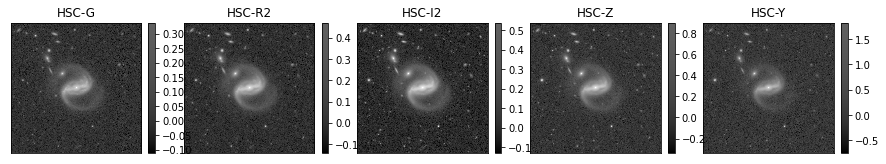

In [14]:
fig, ax = plt.subplots(1,5, figsize=(15, 5))
display = []
for i in range(len(bands)):
    plt.sca(ax[i])
    afw_display = afwDisplay.Display(frame=fig)
    display.append(afw_display)
    display[i].scale("asinh", "zscale")
    display[i].setMaskTransparency(100)
    display[i].mtv(calexps[bands[i]])
    ax[i].set_title(bands[i])
    ax[i].set_xticks([])
    ax[i].set_yticks([])

Everything looks to be in order, so now we can prepare the images for photometry.

## **Part 3: Masking unwanted sources**

In [15]:
from lsst.meas.algorithms import SourceDetectionTask
from lsst.meas.extensions.scarlet.deblend import ScarletDeblendTask
from lsst.meas.base import SingleFrameMeasurementTask
from lsst.afw.table import SourceCatalog

First we will set up our deblender and detection tasks.  This is using the [lsst_stack_deblender tutorial](https://github.com/LSSTScienceCollaborations/StackClub/blob/master/Deblending/lsst_stack_deblender.ipynb) as a baseline, so see that page for more detailed information.  We'll use the I2-band for our detection, which in our images above looks to have a deep sensitivity, and falls in a red wavelength regime that should help pick out more high-redshift objects as well.

The Scarlet deblending requires specifically a multiband exposure object to work with, so first we construct one of those.

In [16]:
# Multiband exposures need a list of images and filters
coadds = [calexps[band] for band in bands[:3]] # Using only the first three filters
coadds = MultibandExposure.fromExposures(bands[:3], coadds)

Now we'll set up our detection and deblending tasks (but we don't run them yet).

In [17]:
schema = SourceCatalog.Table.makeMinimalSchema() # Set up an empty schema

# The source detection
detectionConfig = SourceDetectionTask.ConfigClass()
detectionConfig.thresholdValue = 3  # This is our detection threshold
detectionConfig.thresholdType = "stdev" # Specifying we want it in standard deviations
detectionTask = SourceDetectionTask(schema=schema) # Set up a detection task for the previous schema

In [18]:
# The deblender
deblendConfig = ScarletDeblendTask.ConfigClass()
deblendConfig.maxIter = 100
deblendTask = ScarletDeblendTask(schema=schema, config=deblendConfig)

In [19]:
# The measurements; is this necessary?
measureConfig = SingleFrameMeasurementTask.ConfigClass()
measureConfig.plugins.names = ["base_SdssCentroid", "base_PsfFlux", "base_SkyCoord"]
measureConfig.slots.apFlux = None
measureConfig.slots.shape = None
measureConfig.slots.modelFlux = None
measureConfig.slots.calibFlux = None
measureConfig.slots.gaussianFlux = None
measureTask = SingleFrameMeasurementTask(config=measureConfig, schema=schema)

Now we'll run the detection task on the whole cutout to create the initial mask.  We'll do this using the I2-band, which is the deepest image in the lot.

In [20]:
detectionTable = SourceCatalog.Table.make(schema)
detectionResult = detectionTask.run(detectionTable, calexps['HSC-I2']) # Using only I-band
detectionCatalog = detectionResult.sources

We'll use the coordinates of the calexp bounding box, along with the indexes and values of the footprints, to pinpoint the locations of the footprints on the image thumbnails.  The bounding box mininum is the lower-left corner of the thumbnail (indexes 0,0), so we just subtract that value from the footprint indices to find our coordinates in thumbnail image space.

We'll also identify and then separate out the footprint that contains the galaxy we're interested in.  We do want to preserve this mask for a later step, that being the local sky background estimation (Part 4).

In [21]:
xy_begin = bbox.getMin()
image_I2 = calexps['HSC-I2'].image.array
mask = np.zeros(image_I2.shape) # Masking all detections, except galaxy of interest
sky_mask = np.zeros(image_I2.shape) # Mask all detections, including galaxy of interest, for sky estimation
atol = 50 # Requires a high number: the footprint centroid is not the galaxy centroid

for j in range(len(detectionCatalog['id'])):
    centroid = detectionCatalog[j].getFootprint().getCentroid()
    
    yind, xind = detectionCatalog[j].getFootprint().spans.indices()
    new_yind = np.array(yind, dtype=int) - xy_begin[1] #yind, xind are lists, so we need to convert to do math
    new_xind = np.array(xind, dtype=int) - xy_begin[0]    
    sky_mask[new_yind, new_xind] = np.nan
    
    want1 = np.isclose(centroid[0], xy_begin[0]+bwidth//2, atol=atol)
    want2 = np.isclose(centroid[1], xy_begin[1]+bwidth//2, atol=atol)
    
    if want1 & want2:
        obj_ind = j
        continue
        
    # Now setting all mask pixels to NaN
    mask[new_yind, new_xind] = np.nan

Text(0.5, 1.0, 'Mask for Sky Estimation')

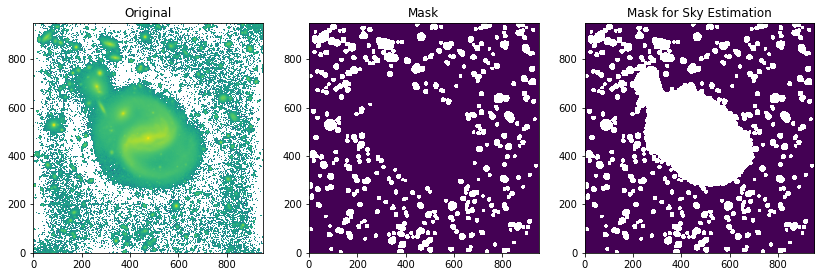

In [22]:
# Checking that our resulting mask makes sense
fig, ax = plt.subplots(figsize=(14, 7), nrows=1, ncols=3)
ax[0].imshow(image_I2, norm=colors.LogNorm(), origin='bottom')
ax[0].set_title('Original')
ax[1].imshow(mask,  origin='bottom')
ax[1].set_title('Mask')
ax[2].imshow(sky_mask,  origin='bottom')
ax[2].set_title('Mask for Sky Estimation')

This shows that we can pick out pixels that belong to everything except the central galaxy and whatever surrounding galaxies are part of the same footprint (right panel) or that we can include the target galaxy mask as well.  Of course, for a more correct mask we also want to include masks around overlapping sources.  Because the current implementation of the deblender in the Stack is out of date, we're going to use the following package:

https://github.com/herjy/scarlet_extensions

To run this notebook from here, you will need to do a git clone on this package in your working directory, then move the scarlet_extensions folder out from the newly created repository.  Also, this package requires SEP, a SExtractor protocol for Python.  This can be installed quite easily: pip install sep (however, make sure you do it in an LSST environment).

In [27]:
import scarlet
import scarlet.display
import lsst.meas.extensions.scarlet as mes
# Moved this from its parent folder after Github download, then had to pip install sep
from scarlet_extensions.initialization import detection as det

In [28]:
images = coadds.image.array
seg_catalog, bg_rms = det.makeCatalog(images)

In [80]:
seg_catalog.dtype

dtype([('thresh', '<f8'), ('npix', '<i8'), ('tnpix', '<i8'), ('xmin', '<i8'), ('xmax', '<i8'), ('ymin', '<i8'), ('ymax', '<i8'), ('x', '<f8'), ('y', '<f8'), ('x2', '<f8'), ('y2', '<f8'), ('xy', '<f8'), ('errx2', '<f8'), ('erry2', '<f8'), ('errxy', '<f8'), ('a', '<f8'), ('b', '<f8'), ('theta', '<f8'), ('cxx', '<f8'), ('cyy', '<f8'), ('cxy', '<f8'), ('cflux', '<f8'), ('flux', '<f8'), ('cpeak', '<f8'), ('peak', '<f8'), ('xcpeak', '<i8'), ('ycpeak', '<i8'), ('xpeak', '<i8'), ('ypeak', '<i8'), ('flag', '<i8')])

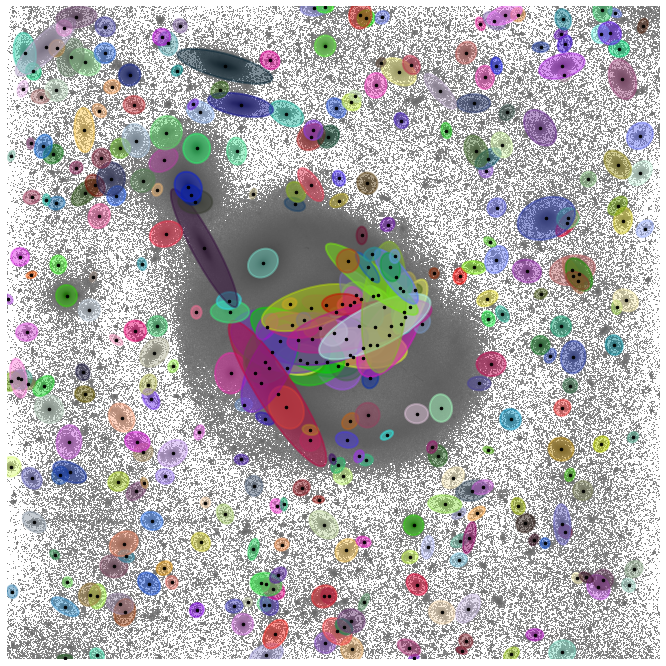

In [86]:
# Temporary: want to see the output on the galaxy image.
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots(figsize=(12,12))
im = ax.imshow(image_I2, norm=colors.LogNorm(), origin='bottom', cmap='Greys')

# plot an ellipse for each object
for i in range(len(seg_catalog)):
    e = Ellipse(xy=(seg_catalog['x'][i], seg_catalog['y'][i]),
                width=20*seg_catalog['a'][i],
                height=20*seg_catalog['b'][i],
                angle=seg_catalog['theta'][i] * 180. / np.pi, 
                lw=2)

    color = list(np.random.uniform(size=3))
    color.append(0.5)
    e.set_facecolor(color)
    e.set_edgecolor(color)
    ax.add_artist(e)
    
plt.axis('off')

ax.plot(seg_catalog['x'], seg_catalog['y'], 'k.', markersize=5)
# Not too bad.  So only thing left is to implement by-hand selection for masks to keep inside galaxy using e.g. Bokeh.

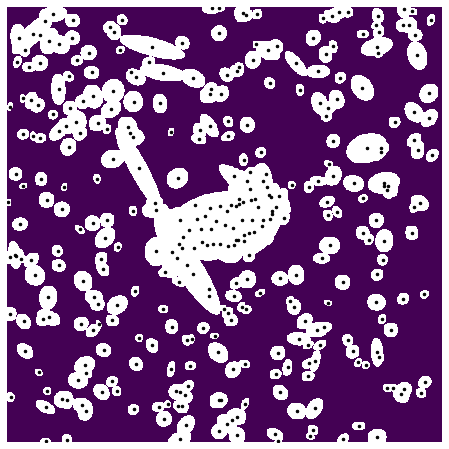

In [78]:
#Alternatively, use sep to create masks of each source using its measured 
#elliptical parameters

import sep 

mask_objects = np.zeros(image_I2.shape)
ellipse_mask_objects = np.zeros(image_I2.shape, dtype=np.bool)
sep.mask_ellipse(ellipse_mask_objects, seg_catalog['x'], seg_catalog['y'], seg_catalog['a'], seg_catalog['b'],
                 seg_catalog['theta'], r=10.)

mask_objects[ellipse_mask_objects] = np.nan 

fig, ax = plt.subplots(figsize=(8,8))
#im = ax.imshow(image_I2, norm=colors.LogNorm(), origin='bottom')

im = ax.imshow(mask_objects, origin='bottom')

loc = ax.plot(seg_catalog['x'], seg_catalog['y'], 'k.', markersize=5)
axoff = plt.axis('off')

## **Part 4: Sky Background Estimation**

In order to do accurate surface photometry, we need an estimate of the local background, to correct for over- or under-subtraction of the sky local to the galaxy.  We will do this using a fairly traditional method, by determining the mean values in a sample of equal-area boxes containing unmasked pixels.  We distribute these boxes randomly in position about the cutout, rejecting boxes if they contain more than 50% masked pixels.

In [ ]:
from astropy.stats import sigma_clipped_stats
meanflux_I2 = np.zeros(1000)
sky_pixels = sky_mask + image_I2

# Setting up random state for box distribution
local_state = np.random.RandomState(2)
dim2, dim1 = sky_pixels.shape # Need to keep boxes within the image cutout
# Sky box size will be 100 x 100 pixels
length = 100
height = 100
for k in range(0, 1000):    
    xc, yc = local_state.randint(low=101, high=dim1-101, size=2)
    # Ensuring the boxes land fully within the image cutout
    x0 = np.round(xc-length//2)
    x1 = np.round(xc+length//2)
    y0 = np.round(yc-height//2)
    y1 = np.round(yc+height//2) 
    
    if x0 < 0: x0 = 0
    if x1 > dim1: x1 = dim1-1
    if y0 < 0: y0 = 0
    if y1 > dim2: y1 = dim2-1
        
    pixels = sky_pixels[y0:y1,x0:x1]    
    if len(np.isfinite(pixels)[np.isfinite(pixels)]) < 0.5*len(pixels):
        meanflux_I2[k] = np.nan
        continue    
    meanflux_I2[k] = np.nanmean(np.ravel(pixels))

stats = sigma_clipped_stats(meanflux_I2[~np.isnan(meanflux_I2)], sigma=3.0)
mean_sky_I2 = stats[1]
sigma_I2_sky = stats[2]
print('mean background value: ', mean_sky_I2)
print('std: ', sigma_I2_sky )